# Notebook to generate RAS maps - pinkbombs
## PROVISIONAL

General imports

In [281]:
import pandas as pd
import numpy as np

In [282]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="darkgrid")

In [283]:
import folium
import branca.colormap as cm
from branca.element import Template, MacroElement
from folium.plugins import GroupedLayerControl

In [284]:
import zipfile 
import os 

In [285]:
import fiona 
import geopandas as gpd 
from bs4 import BeautifulSoup 

In [286]:
import requests

## 1 - Inputs

### 1.1 - RAS dataset adapted from Esther (Google Sheet)
Here we use the dataset put together by Esther and modified/expanded by Antoine/Sarah/Paul (see link to Google Drive below)

https://docs.google.com/spreadsheets/d/1vtZzw8y8IrfWjK2ItR33ApJ0ww10r7_n/edit?usp=sharing&ouid=113313479374754815448&rtpof=true&sd=true

In [299]:
# Load adapted dataset - download from Google sheet
ras_file = "data_ras/Projets RAS Locations.xlsx - RAS.csv" 
projets_ras = pd.read_csv(ras_file) #, encoding='unicode_escape')

In [300]:
projets_ras.columns.values
projets_ras.shape

(144, 26)

In [301]:
projets_ras.head(3)

Company     Parent company Production moyenne  \
0  Andfjord Salmon  (Kvalnes)     Andfjord Salmon                NaN   
1            Atlantic Sapphire  Atlantic Sapphire              1,000   
2               Quality Salmon     Quality Salmon                NaN   

  Production Max Saved Production Max Abattage  \
0         39,000                  NaN     non    
1        200,000                  NaN     oui    
2        100,000                  NaN     non    

                                               Infos  \
0   passage à la phase 2 càd de 1000 à 19000 tonn...   
1  https://www.fishfarmingexpert.com/atlantic-sap...   
2  https://www.seafoodsource.com/news/aquaculture...   

                                 Link info (no text) Technologie  \
0                                                NaN         FTS   
1  https://www.seafoodsource.com/news/aquaculture...         RAS   
2  https://www.intrafish.com/salmon/most-definite...         RAS   

   Etat d'avancement  ... Latest update        Country            Location  \
0  En fonctionnement  ...           NaN         Norway     Kvalnes, Andøya   
1  En fonctionnement  ...        2023.0  United States   Homstead, Florida   
2         Conceptuel  ...        2023.0         Sweden  Sotenäs, Kungshamn   

  Matching Location                   Comment on location  \
0           Kvalnes                                   NaN   
1               NaN  Homstead, Miami-Dade County, Florida   
2         Kungshamn                                   NaN   

                                     Location source   Latitude  Longitude  \
0                                                NaN  69.158148  16.093888   
1  https://www.fishfarmingexpert.com/atlantic-sap...  25.468759 -80.481078   
2  https://www.seafoodsource.com/news/aquaculture...        NaN        NaN   

                                        Errors found Exclude  
0     C'est du FTS (Flow Through Systems) et pas RAS     yes  
1  Correct production from 9,500 to 200,000 based...     NaN  
2                                                NaN     NaN  

[3 rows x 26 columns]

### 1.2 - Carbon emissions by country for Data enrichment  
To represent the carbon footprint on the map, we bring a publicaly available dataset on Carbon intensity by country

https://ourworldindata.org/grapher/carbon-intensity-electricity?tab=table

In [302]:
# Load data for Carbon intensity of electricity generation by country
carbon_file = "data_ras/carbon-intensity-electricity.csv" 
carbon_elec = pd.read_csv(carbon_file) 

In [303]:
# For each country, take most recent data point (2022, if not 2021,...)
carbon_elec22 = carbon_elec.loc[carbon_elec.groupby('Entity').Year.idxmax()]
#carbon_elec22 = carbon_elec.loc[carbon_elec['Year'] == 2022,]
carbon_elec22.head(10)

Entity Code  Year  \
22         ASEAN (Ember)  NaN  2022   
44           Afghanistan  AFG  2021   
66                Africa  NaN  2021   
88        Africa (Ember)  NaN  2021   
110              Albania  ALB  2021   
132              Algeria  DZA  2021   
154       American Samoa  ASM  2021   
176               Angola  AGO  2021   
198  Antigua and Barbuda  ATG  2021   
221            Argentina  ARG  2022   

     Carbon intensity of electricity - gCO2/kWh  
22                                   508.204220  
44                                   120.481926  
66                                   484.696530  
88                                   484.696470  
110                                   23.437498  
132                                  485.489500  
154                                  687.500000  
176                                  195.982960  
198                                  657.142900  
221                                  344.306800

In [304]:
# Show the key countries of interest
#carbon_elec22.sort_values('Carbon intensity of electricity - gCO2/kWh', ascending=False).head(10)
carbon_elec22.loc[carbon_elec22.Entity.isin(['Norway', 'United States', 'France', 
                                             'Portugal', 'China', 'United Kingdom', 
                                             'Iceland', 'Saudi Arabia']), ].sort_values('Carbon intensity of electricity - gCO2/kWh', 
                                                                                        ascending=False)

Entity Code  Year  Carbon intensity of electricity - gCO2/kWh
4114    Saudi Arabia  SAU  2022                                  557.782800
982            China  CHN  2022                                  533.982800
4911   United States  USA  2022                                  368.101960
4888  United Kingdom  GBR  2022                                  261.154900
3834        Portugal  PRT  2022                                  234.604720
1696          France  FRA  2022                                   84.879000
3541          Norway  NOR  2022                                   28.924809
2210         Iceland  ISL  2021                                   28.556593

In [305]:
## Merge with RAS dataset
projets_ras = projets_ras.merge(carbon_elec22, left_on='Country', right_on='Entity', how='left')
#projets_ras.head()

### 1.3 - Conversion parameters
We also need conversion parameters for the farms production. The figure for electricity consumption per kg of salmon produced is from a peer-reviewed publication

https://www.sciencedirect.com/science/article/pii/S0144860923000171

In [306]:
# Electricity consumption per kg of salmon produced
elec_per_kg = 9.59 #kWh/kg == 9.59 * 1000 / tonne

In [307]:
# Convert Production to integer
projets_ras['Production Max'] = projets_ras['Production Max'].apply(lambda x: np.nan if pd.isna(x) else int(x.replace(',','')))

# Calculate Electricity consumption for each farm 
projets_ras['elec_conso_kWh'] = projets_ras['Production Max']*elec_per_kg*1000

In [308]:
# Calculate CO2 emissions for each farm from Electricity consumption of country for each farm
# convert g CO2 into kilotons CO2 (divide by 1e9)
projets_ras['carbon_elec_kt'] = projets_ras['elec_conso_kWh'] * projets_ras['Carbon intensity of electricity - gCO2/kWh']/1e9

The conversion factors between production and C02 emissions are no longer used as it will vary from country to country
- 10 FULL SUPPLY CHAIN inc. transport - WWF - https://www.worldwildlife.org/publications/measuring-and-mitigating-ghgs-salmon
- 5.77 - Agribalyse - https://agribalyse.ademe.fr/app/aliments/26036#Saumon,_cru,_élevage
- 57 - Land-based - Compassion in Animal Farming - CIWF, International Salmon Farmers Association (2015) The evolution of land based Atlantic salmon farms

In [309]:
### NOT USED ####
# Carbon footprint of farmed salmon
#carbon_per_kg = 57 #kg C02 equ / kg LW == 57t C02 / t LW 
# Calculate CO2 emissions directly from production for each farm -- NOT USED
#projets_ras['carbon_footprint_t'] = projets_ras['Production Max']*carbon_per_kg

### 1.4 - Data Filtering - SCOPE
Here we implement the agreed scope for the map:
- Technology: RAS and Hybrid, excluding FTS and SIFT
- Species: Salmon species, so excluding Yellowtail, Shrimp, Trout, Kingfish, Steelhead trout, Rainbow trout
- Etat d'avancement: All status except those abandonned - but keep 'Stopped' (ie. constructed but then stopped).
- Exclude: farm marked as exclude because duplicated or other reason

In [310]:
# For farms with no entry in Species, set to NOT SPECIFIED or 'Atlantic Salmon'???
projets_ras['Species'] = np.where(projets_ras['Species'].isna(), 'Atlantic Salmon', projets_ras['Species'])

In [311]:
# Define criteria lists
techno_no = ['FTS', 'SIFT']
species_no = ['Yellow tail', 'Shrimp', 'Smolt', 'Patagonia King Salmon smolt', 'Steelhead', 
              'Rainbow trout', 'Barramundi and Himalayan Rainbow Trout', 'Trout', 'Kingfish tail']
etat_no = ['Abandon', 'Arrêt']

In [312]:
#projets_ras["Species"].value_counts()
#projets_ras["Technologie"].value_counts()
#projets_ras["Exclude"].value_counts()

In [313]:
# Summary of what we exclude and why
excluded = {'Exclude_yes': sum(projets_ras['Exclude'] == 'yes'),
            'Techno': sum(projets_ras['Technologie'].isin(techno_no)),
            'Species': sum(projets_ras['Species'].isin(species_no)),
            'Etat': sum(projets_ras["Etat d'avancement"].isin(etat_no))}
excluded

{'Exclude_yes': 29, 'Techno': 10, 'Species': 13, 'Etat': 9}

In [314]:
projets_ras = projets_ras.loc[(projets_ras['Exclude'] != 'yes') & 
            (~projets_ras['Technologie'].isin(techno_no)) &
            (~projets_ras['Species'].isin(species_no)) & 
            (~projets_ras["Etat d'avancement"].isin(etat_no)),]

In [315]:
projets_ras.shape

(109, 32)

In [316]:
projets_ras["Species"].value_counts() ## To change in spreadsheet!!! 

Species
Atlantic Salmon                       85
Atlantic salmon                       13
not specified                          2
King Salmon                            2
Atlantic salmon and non-salmonoids     1
Rainbow Trout and Atlantic Salmon      1
Atlantic cod and Atlantic Salmon       1
Altantic salmon                        1
Salmon                                 1
Coho                                   1
Sockeye                                1
Name: count, dtype: int64

## 2 - Exploratory Data Analysis

### 2.1 - Status

In [317]:
# Map fields into english
projets_ras['Detailed status'] = projets_ras["Etat d'avancement"].map({'En construction': 'In construction', 
                                                                       'En fonctionnement': 'Operating',
                                                                       #'Arrêt': 'Stopped',
                                                                       'Blocage Opposition': 'Local opposition',
                                                                       'Blocage financier': 'Financial block',
                                                                       'Bloquage législatif': 'Legal block',
                                                                       'Conceptuel': 'Conceptual',
                                                                       'Permis': 'Permit'})

In [318]:
#projets_ras.groupby(["Detailed status", "Etat d'avancement"]).size()

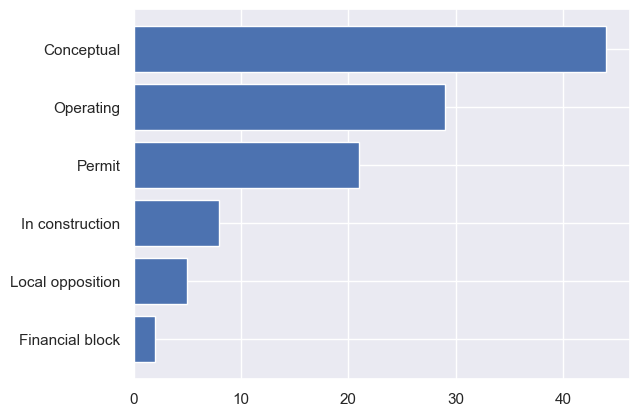

In [319]:
# Histogram of stages
df = projets_ras['Detailed status'].value_counts().reset_index().sort_values(by=['count'])
plt.barh(y=df['Detailed status'], width=df['count'])
plt.show()

In [320]:
# Categorise Detailed status into 3 status in english
concept = ['Local opposition', 'Financial block', 'Legal block', 'Conceptual', 'Permit']
projets_ras['Status'] = np.where(projets_ras['Detailed status'].isin(concept), 'Project', projets_ras['Detailed status'])
projets_ras.groupby(["Status", 'Detailed status']).size()

Status           Detailed status 
In construction  In construction      8
Operating        Operating           29
Project          Conceptual          44
                 Financial block      2
                 Local opposition     5
                 Permit              21
dtype: int64

In [321]:
# Aggregate the table by countries and detailed status
ras_country = projets_ras.groupby(["Country", "Detailed status"]).size().reset_index()
ras_country.columns = ["Country", "Detailed status", "count"]
ras_country = ras_country.pivot_table(values='count', index=['Country'], columns=["Detailed status"], aggfunc="sum").fillna(0).reset_index()

In [323]:
# Caluclate total number of farms for each country
col_sum = ['In construction', 'Operating','Local opposition', 'Financial block', 'Conceptual', 'Permit']
ras_country['tot_ras_farms'] = ras_country[col_sum].sum(axis=1)
ras_country.sort_values('tot_ras_farms', ascending=False).head()

Detailed status        Country  Conceptual  Financial block  In construction  \
13                      Norway         8.0              1.0              3.0   
26               United States         3.0              1.0              1.0   
4                        China         3.0              0.0              0.0   
9                        Japan         2.0              0.0              1.0   
2                       Canada         1.0              0.0              0.0   

Detailed status  Local opposition  Operating  Permit  tot_ras_farms  
13                            0.0        5.0    18.0           35.0  
26                            2.0        4.0     0.0           11.0  
4                             0.0        4.0     0.0            7.0  
9                             0.0        2.0     0.0            5.0  
2                             0.0        3.0     0.0            4.0

### 2.1 - Energy Consumption

Text(0, 0.5, 'Number of farms')

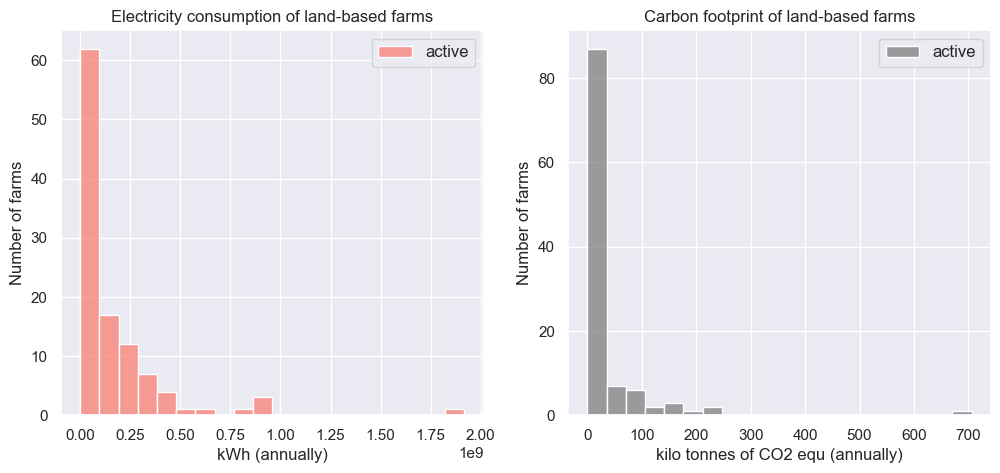

In [324]:
# Histogram of Elec conso & Carbon footprint
fig, axs = plt.subplots(1, 2, figsize=(12,5))
sns.set(style="darkgrid")
sns.histplot(projets_ras['elec_conso_kWh'], label='active', bins=20, color="salmon", ax = axs[0])
axs[0].legend(prop={'size': 12})
axs[0].set_title('Electricity consumption of land-based farms')
axs[0].set_xlabel('kWh (annually)')
axs[0].set_ylabel('Number of farms')

sns.histplot(projets_ras['carbon_elec_kt'], label='active', bins=20, color="gray", ax = axs[1])
axs[1].legend(prop={'size': 12})
axs[1].set_title('Carbon footprint of land-based farms')
axs[1].set_xlabel('kilo tonnes of CO2 equ (annually)')
axs[1].set_ylabel('Number of farms')

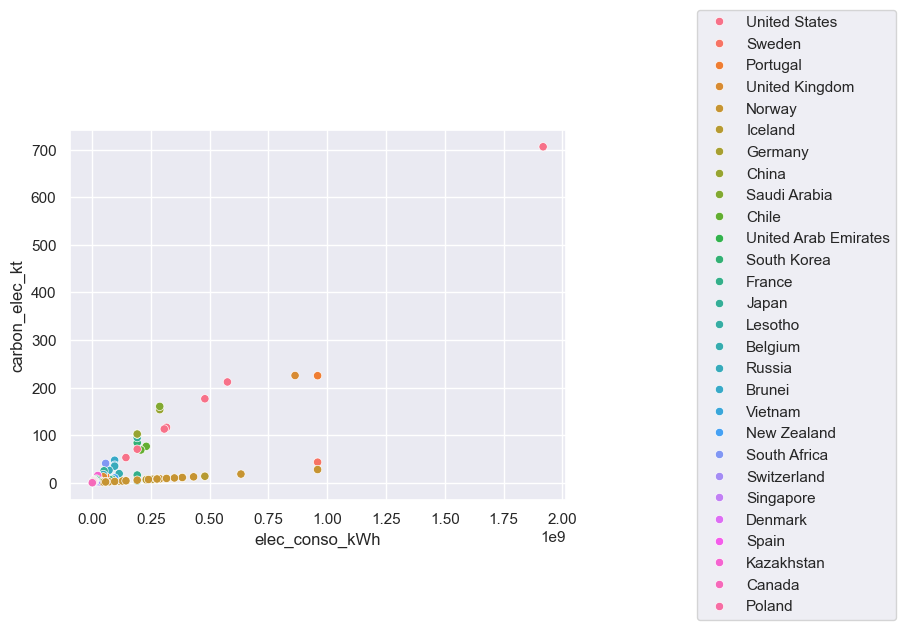

In [325]:
## Plot Carbon footprint vs. elec production
fig, axs = plt.subplots(1, 1)
sns.set(style="darkgrid")
sns.scatterplot(data=projets_ras, x='elec_conso_kWh', y='carbon_elec_kt', hue='Country', ax = axs)
axs.legend(loc='center left', bbox_to_anchor=(1.25, 0.5), ncol=1)

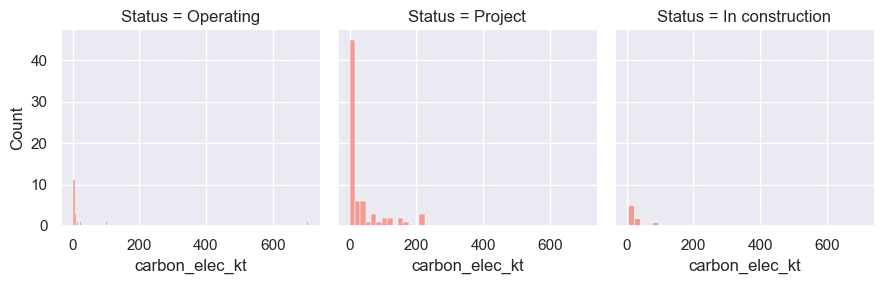

In [326]:
g = sns.FacetGrid(projets_ras, col="Status")
g.map(sns.histplot, 'carbon_elec_kt', color="salmon")

## 3 - Transform dataset into geopandas with Lat/Long Coordinates
The manual data collection involves finding the village/town of the farm, which can be associated with coordinates (Latitude, Longitude) automatically using the opendatasoft database for town > 1000 inhabitants (link below). For the farms in smaller village or if the town has a too common name, the coordinates were entered manually using Google maps. As a result, in this section, we bring the coordinates for part of the dataset, create geopandas datasets and join them back together.

https://public.opendatasoft.com/api/explore/v2.1/catalog/datasets/geonames-all-cities-with-a-population-1000/exports/json?lang=en&timezone=Europe%2FBerlin

In [327]:
# Load coordinates dataset 
cities = gpd.read_file('data_ras/geonames-all-cities-with-a-population-1000.geojson')
#cities.head()

In [328]:
#cities.cou_name_en.value_counts().reset_index().head(50)

In [329]:
# New column for country names to match geo dataset
projets_ras['CountryG'] = projets_ras['Country']
projets_ras.loc[projets_ras['CountryG'] == 'Russia', 'CountryG'] = 'Russian Federation'
projets_ras.loc[projets_ras['CountryG'] == 'Vietnam', 'CountryG'] = 'Viet Nam'
projets_ras.loc[projets_ras['CountryG'] == 'Brunei', 'CountryG'] = 'Brunei Darussalam'

### 3.1 - Part 1
Farms with existing Lat/Long coordinates in the input file

In [330]:
# PART 1 - Farms with LatLong coord
projets_ras_co1 = projets_ras.loc[projets_ras['Latitude'].isna() == False,]
projets_ras_co1.shape

(70, 35)

In [331]:
# Create geopandas
projets_ras_co1_gpd = gpd.GeoDataFrame(projets_ras_co1,
                                 geometry=gpd.points_from_xy(projets_ras_co1['Longitude'], projets_ras_co1['Latitude']), 
                                 crs="EPSG:4326")
projets_ras_co1_gpd.head(3)
#projets_ras_co1_gpd.shape

Company             Parent company Production moyenne  \
1          Atlantic Sapphire          Atlantic Sapphire              1,000   
5  Norwegian Mountain Salmon  Norwegian Mountain Salmon                NaN   
9                 Ardal Aqua                 Ardal Aqua                NaN   

   Production Max Saved Production Max Abattage  \
1        200000.0                  NaN     oui    
5         90000.0                  NaN      NaN   
9         15000.0                3,000     non    

                                               Infos  \
1  https://www.fishfarmingexpert.com/atlantic-sap...   
5  https://thefishsite.com/articles/is-lewis-set-...   
9   https://www.seafoodsource.com/news/aquacultur...   

                                 Link info (no text)     Technologie  \
1  https://www.seafoodsource.com/news/aquaculture...             RAS   
5  https://thefishsite.com/articles/is-lewis-set-...  Hybrid FTS/RAS   
9   https://www.seafoodsource.com/news/aquacultur...             RAS   

   Etat d'avancement  ...          Entity Code  Year  \
1  En fonctionnement  ...   United States  USA  2022   
5         Conceptuel  ...  United Kingdom  GBR  2022   
9    En construction  ...          Norway  NOR  2022   

  Carbon intensity of electricity - gCO2/kWh elec_conso_kWh carbon_elec_kt  \
1                                 368.101960   1.918000e+09     706.019559   
5                                 261.154900   8.631000e+08     225.402794   
9                                  28.924809   1.438500e+08       4.160834   

   Detailed status           Status        CountryG  \
1        Operating        Operating   United States   
5       Conceptual          Project  United Kingdom   
9  In construction  In construction          Norway   

                     geometry  
1  POINT (-80.48108 25.46876)  
5   POINT (-7.10202 58.10483)  
9    POINT (6.16721 59.15153)  

[3 rows x 36 columns]

In [332]:
#sum(projets_ras_co1_gpd['geometry'].isna())

### 3.2 - Part 2
Farms where we need to match the location. We only use regular matching here against the Matching location and country. No fuzzy matching is implemented.

In [333]:
# Check data issues
projets_ras.loc[(projets_ras['Location'].isna()) & (projets_ras['Latitude'].isna()),
['Company', 'Parent company', 'Technologie', "Etat d'avancement", 'Location','Matching Location', 'Latitude','Errors found','Exclude']]

Empty DataFrame
Columns: [Company, Parent company, Technologie, Etat d'avancement, Location, Matching Location, Latitude, Errors found, Exclude]
Index: []

In [334]:
# Part 2 - Farms with no coordinates but locations  --> simple matching
projets_ras_loc = projets_ras.loc[(projets_ras['Location'].isna() == False) & (projets_ras['Latitude'].isna()),]

In [335]:
# Merge geometry to original dataset
#projets_ras_locxy = projets_ras_loc.merge(cities_sub[['name', 'geometry']], left_on='Location', right_on='name', how='left')
#type(projets_ras_locxy)

In [336]:
# Match on location AND country
projets_ras_locxyB = projets_ras_loc.merge(cities[['name', 'cou_name_en', 'geometry']], how='left',
                                           left_on=['Matching Location', 'CountryG'], 
                                           right_on=['name', 'cou_name_en'])

In [337]:
# How many not found?
sum(projets_ras_locxyB['name'].isna())

0

In [338]:
## Show those not found through matching
projets_ras_locxyB.loc[projets_ras_locxyB['name'].isna(),['Company', 'Country', 'CountryG', 'Location', 'Matching Location', 
                                                          'Comment on location', 'name', 'geometry']]

Empty DataFrame
Columns: [Company, Country, CountryG, Location, Matching Location, Comment on location, name, geometry]
Index: []

In [339]:
# Set dataframe for part 2 dropping the 2 columns not in part 1
projets_ras_co2 = projets_ras_locxyB.loc[projets_ras_locxyB['name'].isna() == False,].drop(columns=['name', 'cou_name_en'])

In [340]:
#projets_ras_co2.columns.values
projets_ras_co2.shape

(41, 36)

In [341]:
# Put into GeoDataFrame
projets_ras_co2_gpd = gpd.GeoDataFrame(projets_ras_co2)
#projets_ras_co2_gpd.head()

### 3.3 - Combine Part 1 and 2 and checks
Here we combine the 2 geodataframes together and check that all the farms in scope (Section 2) have the fields required for mapping (Lat/Long) and for display on the pop-up windows. 

In [342]:
# Combine Part 1 and Part 2
projets_ras_co_gpd = pd.concat([projets_ras_co1_gpd, projets_ras_co2_gpd]).reset_index()

In [343]:
projets_ras_co_gpd.tail(3)

index                 Company          Parent company Production moyenne  \
108     38      Blue Horizon Coho       Blue Horizon Coho                 NaN   
109     39                BDV /SAS                BDV /SAS                NaN   
110     40  West Creek Aquaculture  West Creek Aquaculture                NaN   

     Production Max Saved Production Max Abattage  \
108           500.0                  NaN     oui    
109           100.0                  NaN     oui    
110            90.0                  NaN      NaN   

                                                 Infos  \
108   https://www.hishingsmart.com/projects/dongyin...   
109  https://www.pdm-seafoodmag.com/lactualite/saum...   
110  https://www.salmonbusiness.com/these-are-the-l...   

                                   Link info (no text) Technologie  ...  \
108                                                NaN         NaN  ...   
109                                                NaN         RAS  ...   
110  https://www.salmonbusiness.com/these-are-the-l...     Unknown  ...   

     Entity Code  Year Carbon intensity of electricity - gCO2/kWh  \
108   China  CHN  2022                                  533.98280   
109  France  FRA  2022                                   84.87900   
110  Canada  CAN  2022                                  125.84192   

    elec_conso_kWh carbon_elec_kt Detailed status     Status CountryG  \
108      4795000.0       2.560448       Operating  Operating    China   
109       959000.0       0.081399       Operating  Operating   France   
110       863100.0       0.108614       Operating  Operating   Canada   

                        geometry  
108   POINT (118.49165 37.46271)  
109    POINT (-1.10384 49.31604)  
110  POINT (-121.76926 49.23298)  

[3 rows x 37 columns]

In [344]:
projets_ras_co_gpd.shape

(111, 37)

In [345]:
# To save dataset as csv and construct map elsewhere, we save the lat/long or y/x for all
projets_ras_co_gpd['Lat'] = projets_ras_co_gpd['geometry'].y
projets_ras_co_gpd['Long'] = projets_ras_co_gpd['geometry'].x

In [346]:
#projets_ras_co_gpd[['Lat', 'Long', 'Latitude', 'Longitude', 'geometry']]

In [347]:
#projets_ras_co_gpd.columns.values

In [348]:
# Checks where data is missing !!! should 0 everywhere!!!
needed = ['Parent company', 'Production Max', 'Link info (no text)', 'Technologie', 'Species', 
              'Latest update', 'Country', 'Location', 'Location source', 
              'Carbon intensity of electricity - gCO2/kWh', 
              'elec_conso_kWh',
              'carbon_elec_kt', 
              'Detailed status', 'Status', 'Lat', 'Long']   
projets_ras_co_gpd[needed].isna().sum()

Parent company                                 0
Production Max                                 0
Link info (no text)                           20
Technologie                                   17
Species                                        0
Latest update                                 14
Country                                        0
Location                                       0
Location source                                3
Carbon intensity of electricity - gCO2/kWh     0
elec_conso_kWh                                 0
carbon_elec_kt                                 0
Detailed status                                0
Status                                         0
Lat                                            0
Long                                           0
dtype: int64

### 3.4 - Save outputs for pinkbombs Dashboard (current) pipeline
Here we need to save the datasets with the fields required so it can be put on Github and be publically available. This dataset needs to be able to re-generate the map for the Dashboard on the pinkbombs website. In addition, we do an aggregation by company and save the top producers for another figure for the Dashboard.

In [349]:
# Output the data as csv - only what is needed for the map
projets_ras_co_gpd[needed].to_csv("data_ras/Projets RAS Locations_manipulated.csv")

In [350]:
# Aggreate by parent company
projets_ras_company = projets_ras_co_gpd.groupby('Parent company').agg({'Production Max': 'sum',
                                                                        'Company': 'count',
                                                                        'Country': 'unique'}).reset_index()
projets_ras_company['Countries'] = projets_ras_company['Country'].apply(lambda x: ', '.join(x))
projets_ras_company = projets_ras_company.rename(columns={'Company': 'Number of farms'}).drop(columns=['Country'])

In [351]:
# Top 10 are companies with > 50,000 tonnes production ambitions
projets_ras_company.sort_values('Production Max', ascending=False).head(12)

Parent company  Production Max  Number of farms  \
7           Atlantic Sapphire        200000.0                1   
63                Pure Salmon        140000.0                7   
57  Norwegian Mountain Salmon        115000.0                2   
48               Maiken Foods        106000.0                2   
65             Quality Salmon        100000.0                1   
91      World Heritage Salmon        100000.0                1   
70             Sande Aqua AS          66000.0                1   
68           Salmon Evolution         60800.0                2   
88         West Coast Salmon          60000.0                1   
56                    Norsal          60000.0                2   
29                First Water         50000.0                1   
90               Whole Oceans         50000.0                1   

                                            Countries  
7                                       United States  
63  Saudi Arabia, United States, China, France, Ja...  
57                             United Kingdom, Norway  
48                                           Portugal  
65                                             Sweden  
91                                             Norway  
70                                             Norway  
68                              United States, Norway  
88                                      United States  
56                                              China  
29                                            Iceland  
90                                      United States

In [352]:
# Save top 10 in csv file
projets_ras_company.sort_values('Production Max', ascending=False).head(10).to_csv("data_ras/Projets RAS Company_top10.csv")

## 4 - Map
Here we construct the map in folium

### 4.1 - Maps elements: pop-up box

In [60]:
# Check range of number for display
projets_ras_co_gpd['elec_conso_GWh'] = projets_ras_co_gpd['elec_conso_kWh']/1e6
projets_ras_co_gpd[['elec_conso_kWh','elec_conso_GWh','Production Max','carbon_elec_kt', 
                    'Carbon intensity of electricity - gCO2/kWh']].agg(['min', 'max'])

elec_conso_kWh  elec_conso_GWh  Production Max  carbon_elec_kt  \
min    3.836000e+05          0.3836            40.0        0.011096   
max    1.918000e+09       1918.0000        200000.0      706.019559   

     Carbon intensity of electricity - gCO2/kWh  
min                                    20.00000  
max                                   708.20654

In [61]:
# Create strings to display on box
projets_ras_co_gpd['Electricity consumption (annual) [GWh]'] = projets_ras_co_gpd['elec_conso_GWh'].apply(
    lambda x: "{:,.2f}".format(x))
projets_ras_co_gpd['Production Capacity (annual) [tonnes]'] = projets_ras_co_gpd['Production Max'].apply(
    lambda x: format(int(x), "8,d"))
projets_ras_co_gpd['Carbon Footprint (annual) [kilo tonnes C02 equ]'] = projets_ras_co_gpd['carbon_elec_kt'].apply(
    lambda x: format(x, ".2f"))
projets_ras_co_gpd['Country carbon intensity of electricity [gCO2/kWh]'] = projets_ras_co_gpd['Carbon intensity of electricity - gCO2/kWh'].apply(
    lambda x: format(x, ".2f"))
#projets_ras_co_gpd = projets_ras_co_gpd.rename(columns={'Production Max': 'Production Capacity (annual) [tonnes]'})
#projets_ras_co_gpd['Carbon intensity of electricity in country [gCO2/kWh]'] = projets_ras_co_gpd['Carbon intensity of electricity - gCO2/kWh'].apply(
#    lambda x: format(int(x), "8,d"))

In [62]:
projets_ras_co_gpd[['elec_conso_GWh','Electricity consumption (annual) [GWh]',
                   'Production Max','Production Capacity (annual) [tonnes]',
                   'carbon_elec_kt', 'Carbon Footprint (annual) [kilo tonnes C02 equ]',
                   'Carbon intensity of electricity - gCO2/kWh', 'Country carbon intensity of electricity [gCO2/kWh]']].head(5) #.tail()

elec_conso_GWh Electricity consumption (annual) [GWh]  Production Max  \
0         1918.00                               1,918.00        200000.0   
1          863.10                                 863.10         90000.0   
2          143.85                                 143.85         15000.0   
3          191.80                                 191.80         20000.0   
4          230.16                                 230.16         24000.0   

  Production Capacity (annual) [tonnes]  carbon_elec_kt  \
0                               200,000      706.019559   
1                                90,000      225.402794   
2                                15,000        4.160834   
3                                20,000        5.547778   
4                                24,000        6.657334   

  Carbon Footprint (annual) [kilo tonnes C02 equ]  \
0                                          706.02   
1                                          225.40   
2                                            4.16   
3                                            5.55   
4                                            6.66   

   Carbon intensity of electricity - gCO2/kWh  \
0                                  368.101960   
1                                  261.154900   
2                                   28.924809   
3                                   28.924809   
4                                   28.924809   

  Country carbon intensity of electricity [gCO2/kWh]  
0                                             368.10  
1                                             261.15  
2                                              28.92  
3                                              28.92  
4                                              28.92

In [63]:
#projets_ras_co_gpd['Location source']
#projets_ras_co_gpd['Link info (no text)']

In [64]:
# Create hyperlinks
projets_ras_co_gpd['Location source link'] = projets_ras_co_gpd['Location source'].apply(lambda x: f"<a href={x}>Online article</a>")
projets_ras_co_gpd['Information source link'] = projets_ras_co_gpd['Link info (no text)'].apply(lambda x: f"<a href={x}>Online article</a>")

In [65]:
# Add hyperlink for the Carbon Electricity by country
carbon_intensity_link = 'https://ourworldindata.org/grapher/carbon-intensity-electricity'
projets_ras_co_gpd['Country carbon intensity of electricity [gCO2/kWh] link'] = projets_ras_co_gpd['Country carbon intensity of electricity [gCO2/kWh]'].apply(lambda x: f"<a href={carbon_intensity_link}>{x}</a>")


In [66]:
#projets_ras_co_gpd[['Location source link', 'Information source link', 'Country carbon intensity of electricity [gCO2/kWh] link']]

In [68]:
# Choose fields to display in pop-up
fields = [
    'Parent company',
    'Technologie',
    'Species',
    'Country',
    'Location',
    'Location source link',
    'Status',
    'Detailed status',
    'Production Capacity (annual) [tonnes]',
    'Information source link',
    'Latest update',
    'Electricity consumption (annual) [GWh]',
    'Country carbon intensity of electricity [gCO2/kWh] link',
    'Carbon Footprint (annual) [kilo tonnes C02 equ]',
]
aliases=[
    "Company:",
    "Technology:",
    "Salmon species:",
    "Country:",
    "Location (approx):",
    "Location (source):",
    "Status:",
    "Detailed status:",
    "Production Capacity (annual) [tonnes]:",
    "Information (source):",
    "Latest update found (year):",
    "Electricity consumption (annual) [GWh]:",
    "Country carbon intensity of electricity [gCO2/kWh]:",
    "Carbon Footprint (annual) [kilo tonnes C02 equ]:",
]

### 4.2 - Maps element: Bubble radius

In [69]:
def get_transfo_param(df, col, min_rad=2.5, max_rad=60):
    """Returns the linear parameters to convert a dataframe field for display as bubble on a map 
            Parameters:
                    df (DataFrame): Dataframe containing data to display
                    col (str): Name of the column to display as bubble on the map
                    min_rad (float): min size of circle on the map, default is 2.5
                    max_rad (float): min size of circle on the map, default is 60
            Returns:
                    (slope, intercept) (pair): Pair of float as parameters of the linear transformation
    """  
    minx = df[col].min()
    maxx = df[col].max()
    slope = (max_rad - min_rad)/(maxx - minx) 
    intercept = max_rad - slope * maxx 
    return (slope, intercept)

In [70]:
# Determine transformation for display on the map - ELECTRICITY
(a_elec, b_elec) = get_transfo_param(projets_ras_co_gpd, 'elec_conso_GWh', min_rad=2.5, max_rad=60)
(a_elec, b_elec)

(0.029985141971042798, 2.488497699539913)

In [71]:
# Determine transformation for display on the map - CARBON
(a_carbon, b_carbon) = get_transfo_param(projets_ras_co_gpd, 'carbon_elec_kt', min_rad=2.5, max_rad=60)
(a_carbon, b_carbon)

(0.08144378283620426, 2.499096335887039)

### 4.3 - Maps element: Colors

Colors from https://creativebooster.net/blogs/colors/shades-of-salmon-color
and https://creativebooster.net/blogs/colors/purple-color-palettes

In [254]:
# Define list of 4 colors for each Status
shades_salmon = ['#CBC1AE', #oyster grey --> Stopped
                 '#C66264', #deep salmon --> Operating
                 '#fa8072', #salmon --> In construction
                 '#FEA993', #light salmon --> Project
                ]
shades_purple = ['#CBC1AE', #oyster grey --> Stopped
                 '#7E3285', #deep purple --> Operating
                 '#9F5EA5', #purple --> In construction
                 '#E0B6E4', #light purple --> Project
                ]

In [255]:
# Define colors indeces
projets_ras_co_gpd['Status_col'] = np.where(projets_ras_co_gpd["Status"] == 'Stopped', 0, 
                                            np.where(projets_ras_co_gpd["Status"] == 'Operating', 1, 
                                                     np.where(projets_ras_co_gpd["Status"] == 'In construction', 2, 3)))
#projets_ras_co_gpd.groupby(['Status', 'Status_col']).size()

### 4.4 - Maps element: Functions for bubbles by layers

In [256]:
# Function to shorten the code
def make_geojson_layer(temp_geojson0, fields, aliases, mylistcol, modality, a, b):  
    layer = folium.GeoJson(
            temp_geojson0,
            control=False,
            marker = folium.CircleMarker(radius = 1, weight = 2, color = 'black', fill_color = '#000000', fill_opacity = 0.6, opacity = 0.8),
            style_function=lambda x: {
                "fillColor": mylistcol[x['properties']['Status_col']],
                "color": mylistcol[x['properties']['Status_col']],
                "radius": (x['properties'][modality]* a + b),
                "fillOpacity": 0.6,
            },
            popup=folium.GeoJsonPopup(fields=fields, aliases=aliases, localize=True, labels=True, 
                                      style="""background-color: #F0EFEF; border-radius: 3px; box-shadow: 3px;""", max_width=800)
        )
    return layer

In [257]:
# Function to create Map title html
def make_title_html(map_title):
    title_html = '''
             <h3 align="center" style="font-size:16px"><b>{}</b></h3>
             '''.format(map_title)
    return title_html

### 4.5 - Pinkbombs map Option1 - Only electricity with layers for Status

THIS IS WHAT WORKS!!!
Try to break down the geojson to have both layers and pop-ups
#https://github.com/python-visualization/folium/issues/904

In [258]:
# 4 layers by Status
fg1 = folium.FeatureGroup(name='Stopped')
fg2 = folium.FeatureGroup(name='Operating')
fg3 = folium.FeatureGroup(name='In construction')
fg4 = folium.FeatureGroup(name='Project')

In [259]:
# Map centered on World - limit max zoom to avoid too much scrutiny
#map_bubras = folium.Map(location=(53.5,10.0), zoom_start=2, tiles='cartodb positron') #tiles='openstreetmap')
map_elec = folium.Map(location=(0,0), 
                         #max_zoom=5,
                         maxZoom=12,
                         zoom_start=2,
                         zoom_control=True,
                         tiles='cartodb positron') 

In [260]:
# Use geopands in json dictionary format
#len(projets_ras_co_gpd.__geo_interface__['features'])
#projets_ras_co_gpd.__geo_interface__['features'][0]['properties']['Status']

In [261]:
for i in range(len(projets_ras_co_gpd.__geo_interface__['features'])):
    if projets_ras_co_gpd.__geo_interface__['features'][i]['properties']['Status'] == "Stopped":
        temp_geojson = {"features":[projets_ras_co_gpd.__geo_interface__['features'][i]],"type":"FeatureCollection"}
        temp_geojson_layer = make_geojson_layer(temp_geojson, fields, aliases, shades_salmon, 'elec_conso_GWh', a_elec, b_elec)
        temp_geojson_layer.add_to(fg1)

    if projets_ras_co_gpd.__geo_interface__['features'][i]['properties']['Status'] == "Operating":
        temp_geojson = {"features":[projets_ras_co_gpd.__geo_interface__['features'][i]],"type":"FeatureCollection"}
        temp_geojson_layer = make_geojson_layer(temp_geojson, fields, aliases, shades_salmon, 'elec_conso_GWh', a_elec, b_elec)
        temp_geojson_layer.add_to(fg2)

    if projets_ras_co_gpd.__geo_interface__['features'][i]['properties']['Status'] == "In construction":
        temp_geojson = {"features":[projets_ras_co_gpd.__geo_interface__['features'][i]],"type":"FeatureCollection"}
        temp_geojson_layer = make_geojson_layer(temp_geojson, fields, aliases, shades_salmon, 'elec_conso_GWh', a_elec, b_elec)
        temp_geojson_layer.add_to(fg3)

    if projets_ras_co_gpd.__geo_interface__['features'][i]['properties']['Status'] == "Project":
        temp_geojson = {"features":[projets_ras_co_gpd.__geo_interface__['features'][i]],"type":"FeatureCollection"}
        temp_geojson_layer = make_geojson_layer(temp_geojson, fields, aliases, shades_salmon, 'elec_conso_GWh', a_elec, b_elec)
        temp_geojson_layer.add_to(fg4)

In [262]:
#layer_geom.add_to(map_bubras0)
fg1.add_to(map_elec)
fg2.add_to(map_elec)
fg3.add_to(map_elec)
fg4.add_to(map_elec)
folium.LayerControl(autoZIndex=False).add_to(map_elec)

In [263]:
# Add title
map_title = 'PROVISIONAL MAP: Land-based farms and their theoretical Electricity consumption'
map_elec.get_root().html.add_child(folium.Element(make_title_html(map_title)))

In [264]:
#map_elec

### 4.7 - Pinkbombs map Option2 - Electricity AND Carbon with layers

In [265]:
hg1 = folium.FeatureGroup(name='Electricity consumption')
hg2 = folium.FeatureGroup(name='Carbon footprint')

In [266]:
# Map centered on World - limit max zoom to avoid too much scrutiny
map_both = folium.Map(location=(0,0), 
                         #max_zoom=5,
                         maxZoom=12,
                         zoom_start=2,
                         zoom_control=True,
                         tiles='cartodb positron') 

In [267]:
## Option 2 - Apply to the 2 modalities - Electricity / Carbon

for i in range(len(projets_ras_co_gpd.__geo_interface__['features'])):
    temp_geojson = {"features":[projets_ras_co_gpd.__geo_interface__['features'][i]],"type":"FeatureCollection"}

    # Elec
    temp_geojson_layer = make_geojson_layer(temp_geojson, fields, aliases, shades_salmon, 'elec_conso_GWh', a_elec, b_elec)
    temp_geojson_layer.add_to(hg1)

    # Carbon
    temp_geojson_layer = make_geojson_layer(temp_geojson, fields, aliases, shades_purple, 'carbon_elec_kt', a_carbon, b_carbon)
    temp_geojson_layer.add_to(hg2)

In [268]:
hg1.add_to(map_both)
hg2.add_to(map_both)
GroupedLayerControl(
    groups={'Modality': [hg1, hg2]},
    exclusive_groups=True,   # set to False to not have subgroup mutually exclusive
    collapsed=False,
).add_to(map_both)
#folium.LayerControl(autoZIndex=False).add_to(map_bubras)
#folium.LayerControl(autoZIndex=False, collapsed=True).add_to(map_bubras0)

In [269]:
# Add title
map_title = 'PROVISIONAL MAP: Land-based farms and their theoretical Electricity consumption and Carbon footprint'
map_both.get_root().html.add_child(folium.Element(make_title_html(map_title)))

In [270]:
#map_both

### 4.8 - Maps element: Legend

In [271]:
template1 = """
{% macro html(this, kwargs) %}

<!doctype html>
<html lang="en">
<head>
  <meta charset="utf-8">
  <meta name="viewport" content="width=device-width, initial-scale=1">
  <title>jQuery UI Draggable - Default functionality</title>
  <link rel="stylesheet" href="//code.jquery.com/ui/1.12.1/themes/base/jquery-ui.css">

  <script src="https://code.jquery.com/jquery-1.12.4.js"></script>
  <script src="https://code.jquery.com/ui/1.12.1/jquery-ui.js"></script>
  
  <script>
  $( function() {
    $( "#maplegend" ).draggable({
                    start: function (event, ui) {
                        $(this).css({
                            right: "auto",
                            top: "auto",
                            bottom: "auto"
                        });
                    }
                });
});

  </script>
</head>
<body>

"""

In [272]:
template2_elec = """
<div id='maplegend' class='maplegend' 
    style='position: absolute; z-index:9999; border:2px solid grey; background-color:rgba(255, 255, 255, 0.8);
     border-radius:6px; padding: 10px; font-size:14px; left: 20px; bottom: 20px;'>
<div class='legend-title'>Land-based Farms by Status</div>

<div class='legend-scale'>
  <ul class='legend-labels'>
    <li><span style='background:#C66264;opacity:0.7;'></span>Operating</li>
    <li><span style='background:#FA8072;opacity:0.7;'></span>In construction</li>
    <li><span style='background:#FEA993;opacity:0.7;'></span>Project</li>
    <li><span style='background:#CBC1AE;opacity:0.7;'></span>Stopped</li>
"""

In [273]:
template2_carbon = """
<div id='maplegend' class='maplegend' 
    style='position: absolute; z-index:9999; border:2px solid grey; background-color:rgba(255, 255, 255, 0.8);
     border-radius:6px; padding: 10px; font-size:14px; right: 20px; bottom: 20px;'>
<div class='legend-title'>Land-based Farms by Status</div>

<div class='legend-scale'>
  <ul class='legend-labels'>
    <li><span style='background:#7E3285;opacity:0.7;'></span>Operating</li>
    <li><span style='background:#9F5EA5;opacity:0.7;'></span>In construction</li>
    <li><span style='background:#E0B6E4;opacity:0.7;'></span>Project</li>
    <li><span style='background:#CBC1AE;opacity:0.7;'></span>Stopped</li>
"""

In [274]:
template3_elec = """
<div class='legend-subtitle'>Size depends on production and MWh</div>
<li><a href='https://www.sciencedirect.com/science/article/pii/S0144860923000171' target='_blank'>based on 9.59 kWh/kg LW (Ayuso-Virgili et al. 2023)</a></li>
  </ul>
</div>
</div>
 
</body>
</html>
"""

In [275]:
template3_carbon = """
<div class='legend-subtitle'>Size depends on production and</div>
<li><a href='https://ourworldindata.org/grapher/carbon-intensity-electricity ' target='_blank'>Carbon intensity of electricity generation by country</a></li>
  </ul>
</div>
</div>
 
</body>
</html>
"""

In [276]:
template4 = """
<style type='text/css'>
  .maplegend .legend-title {
    text-align: left;
    margin-bottom: 5px;
    font-weight: bold;
    font-size: 90%;
    }
  .maplegend .legend-scale ul {
    margin: 0;
    margin-bottom: 5px;
    padding: 0;
    float: left;
    list-style: none;
    }
  .maplegend .legend-scale ul li {
    font-size: 80%;
    list-style: none;
    margin-left: 0;
    line-height: 18px;
    margin-bottom: 2px;
    }
  .maplegend ul.legend-labels li span {
    display: block;
    float: left;
    height: 16px;
    width: 30px;
    margin-right: 5px;
    margin-left: 0;
    border: 1px solid #999;
    }
  .maplegend .legend-source {
    font-size: 80%;
    color: #777;
    clear: both;
    }
  .maplegend a {
    color: #777;
    }
</style>
{% endmacro %}"""

In [277]:
# Add legend - Elec
template_elec = template1 + template2_elec + template3_elec + template4
macro_elec = MacroElement()
macro_elec._template = Template(template_elec)
map_elec.get_root().add_child(macro_elec)

In [278]:
map_elec.save('outputs/map_ras_bubble_world_elec_PROV_v8.html')

In [279]:
# Add legend - both
template_carbon = template1 + template2_carbon + template3_carbon + template4
macro_carbon = MacroElement()
macro_carbon._template = Template(template_carbon)
map_both.get_root().add_child(macro_elec)
map_both.get_root().add_child(macro_carbon)

In [280]:
map_both.save('outputs/map_ras_bubble_world_both_PROV_v8.html')

### ---- test tree layers -----
Should abailable in latest version 0.16 but is not
https://python-visualization.github.io/folium/latest/user_guide/plugins/treelayercontrol.html

In [74]:
import folium
#from folium.plugins.treelayercontrol import TreeLayerControl
from folium.plugins import TreeLayerControl

#overlay_tree = {
#    "label": "Elec",
#    "select_all_checkbox": "Un/select all",
#    "children": [
#        {
#            "label": "Operating",
#                    "select_all_checkbox": True,
#                    "children": [
#                        { "label": "Tour Eiffel", "layer": Marker([48.8582441, 2.2944775]).add_to(m) },
#                        { "label": "Notre Dame", "layer": Marker([48.8529540, 2.3498726]).add_to(m) },
#                        { "label": "Louvre", "layer": Marker([48.8605847, 2.3376267]).add_to(m) },
#                    ]


SyntaxError: incomplete input (2376957824.py, line 16)

### ---- other tests ----

In [67]:
# Create popups
popup = folium.GeoJsonPopup(
    fields=fields,
    aliases=aliases,
    localize=True,
    labels=True,
    #style="background-color: yellow;",
            #border: 2px solid black;
    style="""
        background-color: #F0EFEF;
        border-radius: 3px;
        box-shadow: 3px;
    """,
    #max_width=800,
)

In [74]:
# Breakdown the geopandas in 4 groups
projets_ras_co_gpd_g1 = projets_ras_co_gpd.loc[projets_ras_co_gpd["Status"] == 'Stopped', ]
projets_ras_co_gpd_g2 = projets_ras_co_gpd.loc[projets_ras_co_gpd["Status"] == 'Operating', ]
projets_ras_co_gpd_g3 = projets_ras_co_gpd.loc[projets_ras_co_gpd["Status"] == 'In construction', ]
projets_ras_co_gpd_g4 = projets_ras_co_gpd.loc[projets_ras_co_gpd["Status"] == 'Project', ]

### --- Layer and pop-ups not working together

In [603]:
g1 = folium.GeoJson(
    projets_ras_co_gpd_g1,
    control = False,
    marker = folium.CircleMarker(radius = 1, 
                                 weight = 2, 
                                 color = 'black',
                                 fill_color = '#000000', 
                                 fill_opacity = 0.6,
                                 opacity = 0.8),
    style_function=lambda x: {
        "fillColor": shades_salmon[x['properties']['Status_col']],
        "color": shades_salmon[x['properties']['Status_col']],
        "radius": (x['properties']['elec_conso_GWh']* a_elec + b_elec),
    },
    #popup=popup,
    tooltip=popup,

).add_to(fg1)

g2 = folium.GeoJson(
    projets_ras_co_gpd_g2,
    control = False,
    marker = folium.CircleMarker(radius = 1, 
                                 weight = 2, 
                                 color = 'black',
                                 fill_color = '#000000', 
                                 fill_opacity = 0.6,
                                 opacity = 0.8),
    style_function=lambda x: {
        "fillColor": shades_salmon[x['properties']['Status_col']],
        "color": shades_salmon[x['properties']['Status_col']],
        "radius": (x['properties']['elec_conso_GWh']* a_elec + b_elec),
        "fillOpacity": 0.6,
    },
    popup=popup,
).add_to(fg2)

#map_bubras.add_child(fg1)
map_bubras.add_child(fg2)
#map_bubras.add_child(fg3)
#map_bubras.add_child(fg4)
folium.LayerControl().add_to(map_bubras)

In [610]:
map_bubras

In [741]:
## try to break down the geojson to have both layers and pop-ups
#https://github.com/python-visualization/folium/issues/904

#layer_geom = folium.FeatureGroup(name='layer',control=False)
fg1 = folium.FeatureGroup(name='Stopped')#, control=False)
fg2 = folium.FeatureGroup(name='Operating')#, control=False)
fg3 = folium.FeatureGroup(name='In construction')
fg4 = folium.FeatureGroup(name='Project')

#for i in range(len(data_geojson_dict["features"])):
for i in range(len(projets_ras_co_gpd.__geo_interface__['features'])):
    if projets_ras_co_gpd.__geo_interface__['features'][i]['properties']['Status'] == "Operating":
        temp_geojson = {"features":[projets_ras_co_gpd.__geo_interface__['features'][i]],"type":"FeatureCollection"}
        temp_geojson_layer = folium.GeoJson(
            temp_geojson,
            control=False,
            marker = folium.CircleMarker(radius = 1, weight = 2, color = 'black', fill_color = '#000000', fill_opacity = 0.6, opacity = 0.8),
            style_function=lambda x: {
                "fillColor": shades_salmon[x['properties']['Status_col']],
                "color": shades_salmon[x['properties']['Status_col']],
                "radius": (x['properties']['elec_conso_GWh']* a_elec + b_elec),
                "fillOpacity": 0.6,
            },
            popup=folium.GeoJsonPopup(fields=fields, aliases=aliases, localize=True, labels=True, 
                                      style="""background-color: #F0EFEF; border-radius: 3px; box-shadow: 3px;""", max_width=800)
        )
        temp_geojson_layer.add_to(fg1)

    if projets_ras_co_gpd.__geo_interface__['features'][i]['properties']['Status'] == "Project":
        temp_geojson = {"features":[projets_ras_co_gpd.__geo_interface__['features'][i]],"type":"FeatureCollection"}
        temp_geojson_layer = folium.GeoJson(
            temp_geojson,
            control=False,
            marker = folium.CircleMarker(radius = 1, weight = 2, color = 'black', fill_color = '#000000', fill_opacity = 0.6, opacity = 0.8),
            style_function=lambda x: {
                "fillColor": shades_salmon[x['properties']['Status_col']],
                "color": shades_salmon[x['properties']['Status_col']],
                "radius": (x['properties']['elec_conso_GWh']* a_elec + b_elec),
                "fillOpacity": 0.6,
            },
            popup=folium.GeoJsonPopup(fields=fields, aliases=aliases, localize=True, labels=True, 
                                      style="""background-color: #F0EFEF; border-radius: 3px; box-shadow: 3px;""", max_width=800)
        )
        temp_geojson_layer.add_to(fg2)


#layer_geom.add_to(map_bubras0)
fg1.add_to(map_bubras0)
fg2.add_to(map_bubras0)
folium.LayerControl(autoZIndex=False).add_to(map_bubras0)
#folium.LayerControl(autoZIndex=False, collapsed=True).add_to(map_bubras0)

In [740]:
map_bubras0

In [612]:
# Add bubbles
for index, row in projets_ras_co_gpd.iterrows():
    if row['Status'] == 'Stopped':
        folium.CircleMarker(
            location=[row['geometry'].y, row['geometry'].x],
            radius=float(row['elec_conso_GWh']* a_elec + b_elec),
            color='#C5C5C5', #'#FF9E85',
            fill=True,
            fill_color='#C5C5C5',
            fill_opacity=0.6,
            opacity=0.8,
            #tooltip = row[fields].to_frame().to_html(),
            popup=popup,
        ).add_to(map_bubras0)

    if row['Status'] == 'Operating':
        folium.CircleMarker(
            location=[row['geometry'].y, row['geometry'].x],
            radius=float(row['elec_conso_GWh']* a_elec + b_elec),
            color='#fa8072', #'#FF9E85',
            fill=True,
            fill_color='#fa8072',
            fill_opacity=0.6,
            opacity=0.8,
            #tooltip = row[fields].to_frame().to_html(),
            popup=popup,
        ).add_to(map_bubras0)

In [613]:
map_bubras0

In [139]:
def add_map_bubbles(map, df, col, a, b, my_colors):
    """Returns folium maps with bubbles for one particular field in the geopandas dataframe 
            Parameters:
                    map (folium object): Folium Map 
                    df (Geopandas DataFrame): Dataframe containing data to display
                    col (str): Name of the column to display as bubble on the map
                    a (float): slope as parameter of the linear transformation
                    b (float): intercept as parameter of the linear transformation
                    my_colors (list): color codes for the 4 different status
            Returns:
                    map (folium object): Folium Map with bubbles added
    """  
    fg1 = folium.FeatureGroup(name='Abandonned')
    fg2 = folium.FeatureGroup(name='Operating')
    fg3 = folium.FeatureGroup(name='In construction')
    fg4 = folium.FeatureGroup(name='Project')
  
    for index, row in df.iterrows():
        if row["Status"] == 'Abandonned':
            folium.CircleMarker(
                location=[row['geometry'].y, row['geometry'].x],
                radius=float(row[col] * a + b),
                color=my_colors[0],
                fill=True,
                fill_color=my_colors[0],
                fill_opacity=0.6,
                opacity=0.8,
                tooltip = row[fields].to_frame().to_html(),
            #).add_to(map)
            ).add_to(fg1)
            
        if row["Status"] == 'Operating':
            folium.CircleMarker(
                location=[row['geometry'].y, row['geometry'].x],
                radius=float(row[col] * a + b),
                color=my_colors[1], 
                fill=True,
                fill_color=my_colors[1],
                fill_opacity=0.6,
                opacity=0.8,
                tooltip = row[fields].to_frame().to_html(),
            ).add_to(fg2)
            
        if row["Status"] == 'In construction':
            folium.CircleMarker(
                location=[row['geometry'].y, row['geometry'].x],
                radius=float(row[col] * a + b),
                color=my_colors[2], 
                fill=True,
                fill_color=my_colors[2],
                fill_opacity=0.6,
                opacity=0.8,
                tooltip = row[fields].to_frame().to_html(),
            ).add_to(fg3)
            
        if row["Status"] == 'Project':
            folium.CircleMarker(
                location=[row['geometry'].y, row['geometry'].x],
                radius=float(row[col] * a + b),
                color=my_colors[3], 
                fill=True,
                fill_color=my_colors[3],
                fill_opacity=0.6,
                opacity=0.8,
                tooltip = row[fields].to_frame().to_html(),
            ).add_to(fg4)

    map.add_child(fg1)
    map.add_child(fg2)
    map.add_child(fg3)
    map.add_child(fg4)
    folium.LayerControl().add_to(map)

    return map

In [140]:
# Add bubbles for Electricity consumption
map_bubras2 = add_map_bubbles(map_bubras1, projets_ras_co_gpd, 'elec_conso_kWh', a_elec, b_elec, shades_salmon)

### 4.3 - Maps element: Title

In [141]:
# Add title 
map_title = 'PROVISIONAL MAP: Land-based farms and their theoretical Electricity consumption'
title_html = '''
             <h3 align="center" style="font-size:16px"><b>{}</b></h3>
             '''.format(map_title)   
map_bubras2.get_root().html.add_child(folium.Element(title_html))

### 4.4 - Maps element: Legend

In [193]:
template1 = """
{% macro html(this, kwargs) %}

<!doctype html>
<html lang="en">
<head>
  <meta charset="utf-8">
  <meta name="viewport" content="width=device-width, initial-scale=1">
  <title>jQuery UI Draggable - Default functionality</title>
  <link rel="stylesheet" href="//code.jquery.com/ui/1.12.1/themes/base/jquery-ui.css">

  <script src="https://code.jquery.com/jquery-1.12.4.js"></script>
  <script src="https://code.jquery.com/ui/1.12.1/jquery-ui.js"></script>
  
  <script>
  $( function() {
    $( "#maplegend" ).draggable({
                    start: function (event, ui) {
                        $(this).css({
                            right: "auto",
                            top: "auto",
                            bottom: "auto"
                        });
                    }
                });
});

  </script>
</head>
<body>

 
<div id='maplegend' class='maplegend' 
    style='position: absolute; z-index:9999; border:2px solid grey; background-color:rgba(255, 255, 255, 0.8);
     border-radius:6px; padding: 10px; font-size:14px; left: 20px; bottom: 20px;'>
"""

In [194]:
template2 = """
<div class='legend-title'>Land-based Farms by Status</div>
<div class='legend-scale'>
  <ul class='legend-labels'>
    <li><span style='background:#C66264;opacity:0.7;'></span>Operating</li>
    <li><span style='background:#FA8072;opacity:0.7;'></span>In construction</li>
    <li><span style='background:#FEA993;opacity:0.7;'></span>Project</li>
    <li><span style='background:#CBC1AE;opacity:0.7;'></span>Abandonned</li>
"""

In [195]:
template3 = """
<div class='legend-subtitle'>Size depends on production and MWh</div>
<li><a href='https://www.sciencedirect.com/science/article/pii/S0144860923000171' target='_blank'>based on 9.59 kWh/kg LW (Ayuso-Virgili et al. 2023)</a></li>
"""

In [196]:
template4 = """
  </ul>
</div>
</div>
 
</body>
</html>

<style type='text/css'>
  .maplegend .legend-title {
    text-align: left;
    margin-bottom: 5px;
    font-weight: bold;
    font-size: 90%;
    }
  .maplegend .legend-scale ul {
    margin: 0;
    margin-bottom: 5px;
    padding: 0;
    float: left;
    list-style: none;
    }
  .maplegend .legend-scale ul li {
    font-size: 80%;
    list-style: none;
    margin-left: 0;
    line-height: 18px;
    margin-bottom: 2px;
    }
  .maplegend ul.legend-labels li span {
    display: block;
    float: left;
    height: 16px;
    width: 30px;
    margin-right: 5px;
    margin-left: 0;
    border: 1px solid #999;
    }
  .maplegend .legend-source {
    font-size: 80%;
    color: #777;
    clear: both;
    }
  .maplegend a {
    color: #777;
    }
</style>
{% endmacro %}"""

In [146]:
template = template1 + template2 + template3 + template4

In [147]:
# Add legend
macro = MacroElement()
macro._template = Template(template)
map_bubras2.get_root().add_child(macro)

In [148]:
map_bubras1.save('outputs/map_ras_bubble_world_elec_PROV_v7.html')

## 5 - Map with Carbon footprint

In [149]:
# Determine transformation for display on the map - CARBON FOOTPRINT
(a_carbon, b_carbon) = get_transfo_param(projets_ras_co_gpd, 'carbon_elec_t', min_rad=2.5, max_rad=60)

In [150]:
(a_carbon, b_carbon)

(8.145189370980717e-05, 2.4933699004805305)

In [151]:
# Map centered on World
map_carbon = folium.Map(location=(0, 0), zoom_start=2, tiles='cartodb positron') #tiles='openstreetmap')

In [152]:
# Add bubbles for Electricity consumption
map_carbon = add_map_bubbles(map_carbon, projets_ras_co_gpd, 'carbon_elec_t', a_carbon, b_carbon, shades_salmon)

In [153]:
# Add title 
map_title = 'PROVISIONAL MAP: Land-based farms and their theoretical Carbon footprint'
title_html = '''
             <h3 align="center" style="font-size:16px"><b>{}</b></h3>
             '''.format(map_title)   
map_carbon.get_root().html.add_child(folium.Element(title_html))

In [154]:
template3_carbon = """
<div class='legend-subtitle'>Size depends on production,</div>
<div class='legend-subtitle'>electricity usage and kg C02 equ</div>
<li><a href='https://www.sciencedirect.com/science/article/pii/S0144860923000171' target='_blank'>based on SOMETHING</a></li>
"""

In [155]:
template = template1 + template2 + template3_carbon + template4

In [156]:
# Add legend
macro = MacroElement()
macro._template = Template(template)
map_carbon.get_root().add_child(macro)

In [158]:
map_carbon.save('outputs/map_ras_bubble_world_carbon_PROV_v7.html')